## Colorizer using Deoldify

> The current notebook is part of [AI Image Editing and Manipulation](https://github.com/afondiel/computer-vision-challenge/blob/main/L2_06_AI_Assisted_Image_Editing_and_Manipulation/) pipeline from [**Computer Vision Challenge**](https://github.com/afondiel/computer-vision-challenge).

<img width="400" height="400" src="https://github.com/afondiel/computer-vision-challenge/blob/main/L2_06_AI_Assisted_Image_Editing_and_Manipulation/docs/pipeline-last.png?raw=true">


|--|Notebook|Demo (Gradio)|
|--|--|--|
||[![Open notebook in Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/afondiel/computer-vision-challenge/blob/main/L2_06_AI_Assisted_Image_Editing_and_Manipulation/notebooks/Colorizer_Deoldify.ipynb)|[HF Space](https://huggingface.co/spaces/afondiel/image-colorizer-deoldify)|

### Installing Dependencies

In [1]:
# Install necessary dependencies
!pip install --upgrade accelerate transformers gradio datasets
!pip install torch torchvision torchaudio fastai timm -U
!pip install gradio_imageslider

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.7/43.7 kB 1.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.4/50.4 kB 720.6 kB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 315.1/315.1 kB 21.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.5/9.5 MB 92.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.8/16.8 MB 83.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 318.7/318.7 kB 24.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 527.3/527.3 kB 34.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 10.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.4/76.4 kB 6.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.9/77.9 kB 6.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 141.9/141.9 kB 12.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 39.9/39.9 MB 23.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [5]:
!git clone https://github.com/jantic/DeOldify.git DeOldify

fatal: destination path 'DeOldify' already exists and is not an empty directory.


In [6]:
cd DeOldify

/content/DeOldify


In [7]:
!pip install -r requirements-colab.txt

### Import libraries


In [17]:
import os
import numpy as np
import torch
from PIL import Image
from io import BytesIO
from deoldify import device
from deoldify.device_id import DeviceId
from deoldify.visualize import get_image_colorizer
from datasets import load_dataset
import gradio as gr
from gradio_imageslider import ImageSlider
import requests
import matplotlib.pyplot as plt

### Preprocessing & Transformation

In [28]:
# Function to install DeOldify and download model weights
def setup_deoldify():
    if not os.path.exists('DeOldify'):
        !git clone https://github.com/jantic/DeOldify.git DeOldify
        !pip install -r DeOldify/requirements-colab.txt

    os.makedirs('models', exist_ok=True)
    model_url = "https://data.deepai.org/deoldify/ColorizeArtistic_gen.pth"
    model_path = "./models/ColorizeArtistic_gen.pth"
    if not os.path.exists(model_path):
        !wget {model_url} -O {model_path}

# Function to check device availability
def get_device():
    if torch.cuda.is_available():
        device.set(device=DeviceId.GPU0)
        print("Using GPU for computation")
    else:
        device.set(device=DeviceId.CPU)
        print("Using CPU for computation")

# Function to load dataset from Hugging Face
def load_test_dataset(dataset_name="afondiel/dummy_images"):
    ds = load_dataset(dataset_name)
    return ds

# Function to preprocess image
def preprocess_image(image):
    image = image.convert("RGB")
    image = image.resize((256, 256))
    image = np.array(image).astype(np.float32) / 255.0
    image_tensor = torch.from_numpy(image).permute(2, 0, 1).unsqueeze(0)
    return image_tensor

# Function to display the image
def display_image(image_tensor, title="Image"):
    image = image_tensor.squeeze(0).permute(1, 2, 0).cpu().numpy()
    image = (image * 255).astype(np.uint8) # Normalize
    image_pil = Image.fromarray(image)
    image_pil.show(title=title)

# Function to display images
def display_images(input_img, output_img):
    """
    Displays the input and output images side by side.

    Args:
        input_img (np.array/pil) : The original input image.
        output_img (np.array/pil) : The colorized output image.
    """
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.title('Original Image')
    # Open the image file using PIL
    img = Image.open(input_img)
    plt.imshow(img, cmap='gray')
    plt.subplot(1, 2, 2)
    plt.title('Output Image')
    plt.imshow(output_img)
    plt.show()

# Function to fetch images from the dataset
def get_input_images(dataset):
    image_list = []
    for example in dataset['test']:
        im = example['image']
        if isinstance(im, str):
            img = Image.open(im)
        elif isinstance(im, dict):
            img = Image.open(BytesIO(requests.get(im['path']).content))
        elif isinstance(im, Image.Image):
            img = im
        else:
            raise ValueError("Invalid image format")
        image_list.append(img)
    return image_list

### Colorizer: Deoldify

In [3]:
!mkdir 'models'
!wget https://data.deepai.org/deoldify/ColorizeArtistic_gen.pth -O ./models/ColorizeArtistic_gen.pth
# !wget https://www.dropbox.com/s/axsd2g85uyixaho/ColorizeStable_gen.pth?dl=0 -O ./models/ColorizeStable_gen.pth


--2024-08-29 20:01:22--  https://data.deepai.org/deoldify/ColorizeArtistic_gen.pth
Resolving data.deepai.org (data.deepai.org)... 169.150.236.98, 2400:52e0:1a00::894:1
Connecting to data.deepai.org (data.deepai.org)|169.150.236.98|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 255144681 (243M) [application/octet-stream]
Saving to: ‘./models/ColorizeArtistic_gen.pth’

./models/ColorizeAr 100%[===================>] 243.32M  4.96MB/s    in 50s     

2024-08-29 20:02:12 (4.91 MB/s) - ‘./models/ColorizeArtistic_gen.pth’ saved [255144681/255144681]



In [12]:
# Function to colorize an image
def colorize_image(selected_model, image_path, render_factor=10):
  """
  Colorize an image using the DeOldify model.

  Args:
      model_path (path): The input image as a tensor.
      selected_model (boolean): The selected model type. If True, the Artistic model is used, otherwise the Stable model is used.
      image_path (str): The path to the input image
      render_factor (float): The noise level.

  Returns:
      output_img (pil): Color image
  """

  # Load the pretrained Artistic Colorizer
  colorizer = get_image_colorizer(artistic=selected_model)

  if image_path is not None and image_path != '':
    output_img = colorizer.get_transformed_image(
      path=image_path,
      render_factor=render_factor,
      watermarked=False,
      post_process=True,
    )
  else:
    print('Provide an image and try again.')
    return None
  return output_img # pil img

Using CPU for computation


/content/DeOldify/fastai/data_block.py:451: UserWarning: Your training set is empty. If this is by design, pass `ignore_empty=True` to remove this warning.
  warn("Your training set is empty. If this is by design, pass `ignore_empty=True` to remove this warning.")
/content/DeOldify/fastai/data_block.py:453: UserWarning: Your validation set is empty. If this is by design, use `split_none()`
                 or pass `ignore_empty=True` when labelling to remove this warning.
  warn("""Your validation set is empty. If this is by design, use `split_none()`
/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  wa

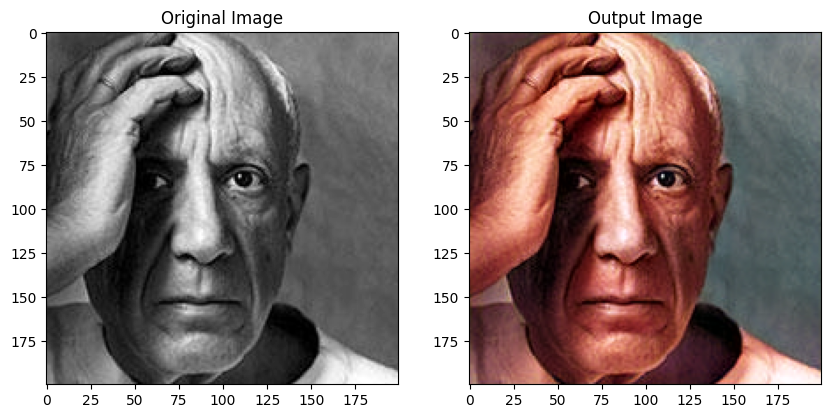

In [29]:
# -----------------------------
# Main: running the App
# -----------------------------
if __name__ == "__main__":
  """
  Colorization process:
  """

  # Setup DeOldify
  setup_deoldify()
  # set device
  get_device()
  # Load dataset & get old images
  dataset = load_test_dataset()
  input_images = get_input_images(dataset)
  old_img_path = 'demo.jpg'
  input_images[1].save(old_img_path)

  # Get render factor
  render_factor = 13 #@param {type:"slider", min:7, max:35, step:2}

  # Colorize the image
  output_img = colorize_image(selected_model=True, image_path=old_img_path, render_factor=render_factor)

  # Display the images
  display_images(old_img_path, output_img)


In [54]:
import gradio as gr

# Function to setup and launch Gradio interface
def launch_gradio_demo():
    def colorizer_fn(input_img, render_factor):
      output_img = colorize_image(
        selected_model=True,
        image_path=input_img,
        render_factor=render_factor
      )
      return (input_img, output_img)

    demo = gr.Interface(
        fn=colorizer_fn,
        inputs=[
            gr.Image(type="filepath", label="Old image"),
            gr.Slider(minimum=0, maximum=40, step=1, label="Render Factor", value=10)
        ],
        outputs=ImageSlider(type="pil", label="Old vs Colored image"),
        title = "AI Image Colorizer",
        description = "Turn your black and white photos/images into colored images with AI",
        # allow_flagging = "never",
        examples = [["./demo.jpg"],]
    )
    demo.launch(share=True)

In [55]:
# launch the demo
launch_gradio_demo()

INFO:httpx:HTTP Request: GET http://127.0.0.1:7863/startup-events "HTTP/1.1 200 OK"


HTTP Request: GET http://127.0.0.1:7863/startup-events "HTTP/1.1 200 OK"


INFO:httpx:HTTP Request: HEAD http://127.0.0.1:7863/ "HTTP/1.1 200 OK"


HTTP Request: HEAD http://127.0.0.1:7863/ "HTTP/1.1 200 OK"


INFO:httpx:HTTP Request: GET https://api.gradio.app/pkg-version "HTTP/1.1 200 OK"


Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
HTTP Request: GET https://api.gradio.app/pkg-version "HTTP/1.1 200 OK"


INFO:httpx:HTTP Request: GET https://api.gradio.app/v2/tunnel-request "HTTP/1.1 200 OK"


HTTP Request: GET https://api.gradio.app/v2/tunnel-request "HTTP/1.1 200 OK"
Running on public URL: https://c50d7fa21a87bd8580.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from Terminal to deploy to Spaces (https://huggingface.co/spaces)


INFO:httpx:HTTP Request: HEAD https://c50d7fa21a87bd8580.gradio.live "HTTP/1.1 200 OK"


HTTP Request: HEAD https://c50d7fa21a87bd8580.gradio.live "HTTP/1.1 200 OK"


## References

**Docs:**

- [AI Image Restoration](https://en.wikipedia.org/wiki/Image_restoration_by_artificial_intelligence)
- [Color Image Pipeline](https://en.wikipedia.org/wiki/Color_image_pipeline)


**Datasets:**

- [Popular Colorization Datasets](https://paperswithcode.com/task/colorization)

**Models:**

- [SOTA Models for Colorization](https://paperswithcode.com/task/colorization)

Deoldify:
- [deoldify.ai](https://deoldify.ai/)
  - [Demo Notebook](https://colab.research.google.com/github/jantic/DeOldify/blob/master/ImageColorizerColab.ipynb#scrollTo=663IVxfrpIAb)

**Papers:**
- [DeOldify: A Review and Implementation of an Automatic
Colorization Method - 2022](https://www.ipol.im/pub/art/2022/403/article_lr.pdf)
- [Enhancing Visual Realism: Fine-Tuning InstructPix2Pix for Advanced Image Colorization](https://arxiv.org/pdf/2312.04780v1)

**Online Tools:**
- https://www.myheritage.com
- https://deepai.org/machine-learning-model/colorizer

**Resources**
- [Yousuf Karsh Collections](https://karsh.org/photographs/)
- [Les meilleurs photographes portraitistes de tous les temps](https://independent-photo.com/fr/news/the-best-portrait-photographers/)